**Employee Turnover using Trees & Forests**<br>
Suppose you want to explain your decision to hiring employees or HR in simplest way about employee turnover.<br>
You must also support your argument just like any data scientist.<br>
Decision trees come handy here.
**Reading**
Read on trees and forests. Also see the interactivity using [@interact decorator](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html).<br>
**Dataset**<br>
Taken from Kaggle.<br>
*Author - Gaurav Kabra*


In [0]:
# De-facto imports
from __future__ import print_function
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
import pandas_profiling
plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [0]:
plt.rcParams['figure.figsize'] = (12,8)

In [3]:
emp = pd.read_csv('./employee_data.csv')
emp.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [0]:
!pip install -U pandas-profiling

     |████████████████████████████████| 245kB 2.8MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 8.7MB 8.4MB/s 
     |████████████████████████████████| 1.5MB 49.0MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 614kB 46.0MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 296kB 42.4MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=6616f2b0e474c164689aafd3fd99fe4f3816eee3540c0af9570fa191f6a90c99
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for tangled-up-in-unicode: filename=tangled_up_in_unicode-0.0.4-cp36-none-any.whl size=1545723 sha256=ffb40adee77ec657b97072c93cab3a2a63dfcc245525bc9f74febc8ca182d7e8
  Stored in directory: /root/.cache/pip/wheels/f9/f1/84/923abc0c2a75358b0bc28f87de02c7aa328c731ce68317d97d
  Created

In [4]:
profile = pandas_profiling.ProfileReport(emp)
profile

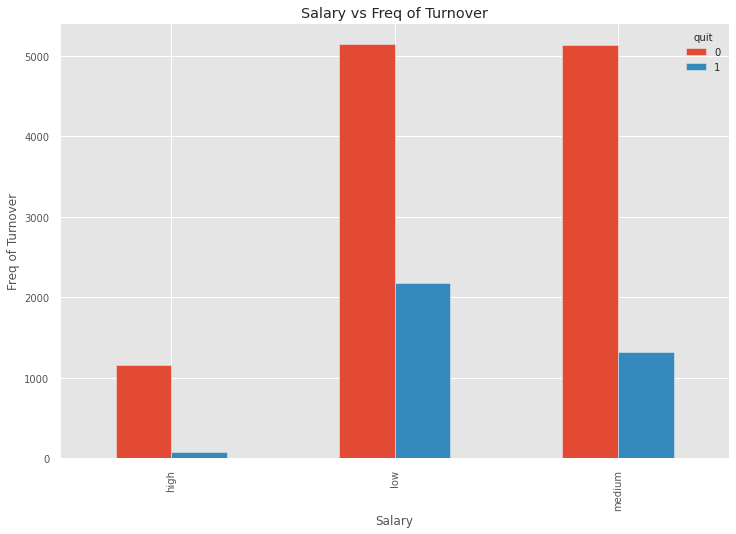

In [5]:
pd.crosstab(emp.salary, emp.quit).plot(kind="bar")
plt.title("Salary vs Freq of Turnover")
plt.xlabel("Salary")
plt.ylabel("Freq of Turnover")
plt.show()

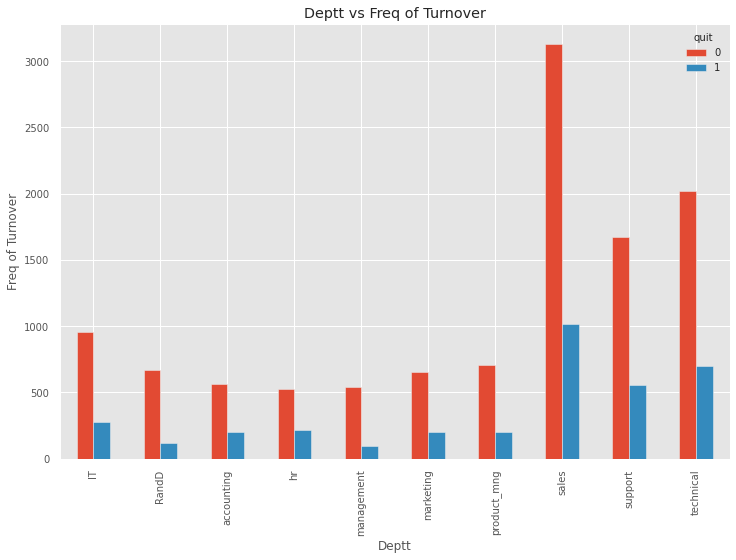

In [6]:
pd.crosstab(emp.department, emp.quit).plot(kind="bar")
plt.title("Deptt vs Freq of Turnover")
plt.xlabel("Deptt")
plt.ylabel("Freq of Turnover")
plt.show()

In [0]:
# to convert categorical variable into dummy/indicator variables
vars = ['salary', 'department']
for var in vars:
  # use prefix so that IT is names as department_IT
  ls = pd.get_dummies(emp[var],prefix=var)
  emp = emp.join(ls)

In [8]:
emp.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary,salary_high,salary_low,salary_medium,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,sales,medium,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,sales,low,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,sales,low,0,1,0,0,0,0,0,0,0,0,1,0,0


In [0]:
# axis=1 is for vertical
emp.drop(vars,axis=1,inplace=True)

In [0]:
from yellowbrick.target import ClassBalance

# Class Imbalance
Even if all parameters fine, accuracy may be compromised if the train and test data don't come from same distribution.<br>
E.g. If in training 90% employees quit the job and in test data only 40% did, then in prediction on test data, our model is surely gonna tell >40%. Hence less accuracy.

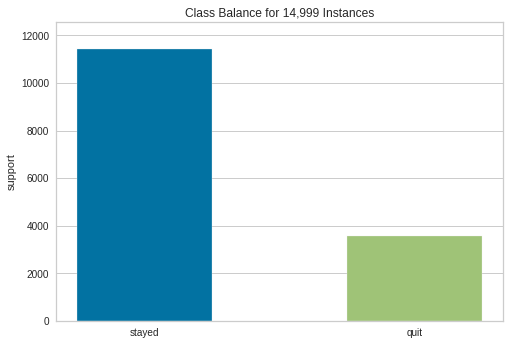

In [11]:
# 0=stayes, 1=quit
visualizer = ClassBalance(labels=['stayed','quit']).fit(emp.quit)
visualizer.poof()

In [0]:
X,y = emp.loc[:,emp.columns!='quit'], emp.quit

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101,train_size=0.8,stratify=y)

**Decision Trees**

In [0]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

In [15]:
@interact
def plot_tree(criteria=['gini','entropy'],
              split=['best','random'],
              depth=IntSlider(min=1,max=25,value=2, continuous_update=True),
              min_split=IntSlider(min=2,max=5,value=2, continuous_update=True),
              min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=True)):
  model = DecisionTreeClassifier(random_state=101, criterion=criteria,splitter=split,max_depth=depth,min_samples_leaf=min_leaf,min_samples_split=min_split)
  model.fit(X_train,y_train)
  print("Decision tree accuracy on X_test {:.3f}".format(accuracy_score(y_test,model.predict(X_test))))
  # visualizer
  graph = Source(tree.export_graphviz(model,filled=True,feature_names=X_train.columns,class_names=['Stayed','quit']))
  display(Image(data=graph.pipe(format='png')))
  return model
    

interactive(children=(Dropdown(description='criteria', options=('gini', 'entropy'), value='gini'), Dropdown(de…

**Random Forests**<br>
Decision trees tend to overfit(high variance problem). So we use forests so as to trade-off bias for variance.
* Randomization and averaging (multiple trees) leads to less variance.
* Bootstrapping is used to reduce training time & memory consumption.
* Implementation are parallelizable. So we can use multiple CPU cores simultaneously.

In [16]:
@interact
def plot_tree_rf(criteria=['gini','entropy'],
                 bootstrap=['True','False'],
                 depth=IntSlider(min=1,max=25,value=2, continuous_update=True),
                 forests=IntSlider(min=1,max=150,value=75,continuous_update=True),
                 min_split=IntSlider(min=2,max=5,value=2, continuous_update=True),
                 min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=True)):
  model = RandomForestClassifier(random_state=101, criterion=criteria,bootstrap=bootstrap,n_estimators=forests,max_depth=depth,min_samples_split=min_split,min_samples_leaf=min_leaf,n_jobs=1,verbose=False)
  model.fit(X_train,y_train)
  print("Random forest accuracy on X_test {:.3f}".format(accuracy_score(y_test,model.predict(X_test))))
  # visualizer for one of the trees
  specific_tree = model.estimators_[0]
  graph = Source(tree.export_graphviz(specific_tree,filled=True,feature_names=X_train.columns,class_names=['Stayed','quit']))
  display(Image(data=graph.pipe(format='png')))
  return model



interactive(children=(Dropdown(description='criteria', options=('gini', 'entropy'), value='gini'), Dropdown(de…

**Important Features**

In [0]:
!pip install -U yellowbrick

     |████████████████████████████████| 266kB 2.8MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


In [0]:
from yellowbrick.model_selection import FeatureImportances

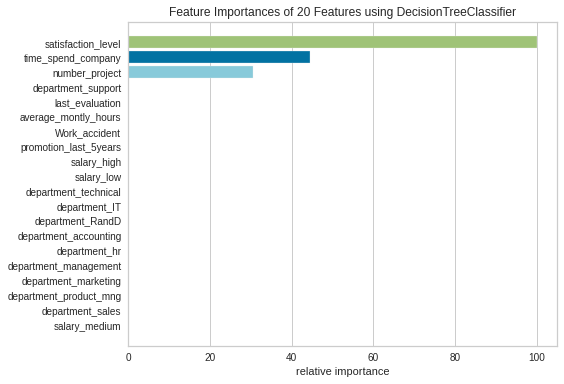

In [19]:
dtc = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=101, splitter='best')
fi = FeatureImportances(dtc)
fi.fit(X_train,y_train)
fi.show()


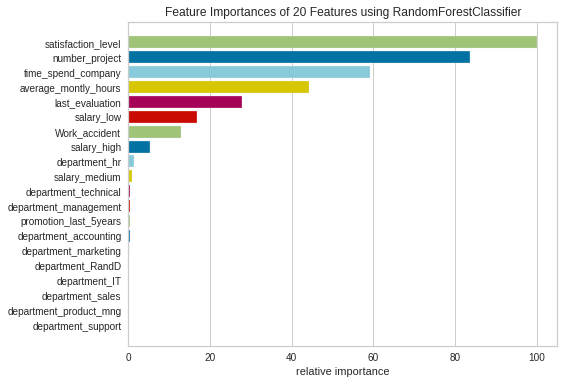

In [20]:
rfc = RandomForestClassifier(bootstrap='True', ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=1,
                       oob_score=False, random_state=101, verbose=False,
                       warm_start=False)
fi = FeatureImportances(rfc)
fi.fit(X_train,y_train)
fi.show()

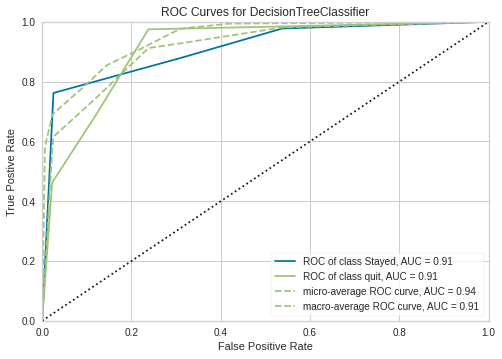

In [21]:
from yellowbrick.classifier import ROCAUC

model = ROCAUC(dtc, classes=['Stayed','quit'])
model.fit(X_train,y_train)
model.score(X_test,y_test)
model.poof()

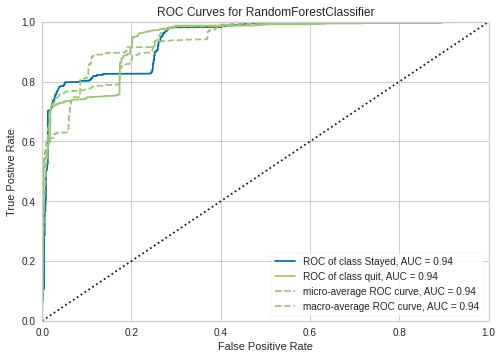

In [22]:
from yellowbrick.classifier import ROCAUC

model = ROCAUC(rfc, classes=['Stayed','quit'])
model.fit(X_train,y_train)
model.score(X_test,y_test)
model.poof()